### Ingests a single set of ADC, HDR and Class files 

Takes the required info from each file and creates single merged file 
Logic Updated to version 3  to contain new logic, class flexibility, and zero roi options
1) Parse ADCFileFormat from .hdr to get column names
2) Load .adc with those headers
3) Add RoiNumber to ADC as 1 - N
4) apply false trigger filterring
5) Tag all rois with RoiX=RoiY=RoiHeight=RoiWidth=0  as IsZeroRoi = 1,  Optionally:  Remove these rows if only care about class 
6) Add InhibitTimeDiff = diff(InhibitTime).fillna(0) -- useful for understanding sample density
7) Add VolumeAnalyzed = (RunTime - InhibitTime) / 240  -- needed for concentration estimates and also useful for understanding sample density
8) Load class CSV and extract RoiNumber from pid ('..._00023' -> 23) -- used to merge with adc file - left merged on ADC File
9) Merge class_df with ADC-derived columns on RoiNumber - for zero rois fill all class scores with 0s
10) Return merged_df (and adc_df, class_df)

This gives you dataset of all rois with class scores and associated ADC metadata

 NOTE: Has been updated use the  version that is below

# Currentlly recomend using Versoion 3 at the bottom for most flexibility

# Version 1 Dont use this !
saved for future incase 

In [99]:
import pandas as pd
from pathlib import Path

def ingest_ifcb(adc_path: str,
                hdr_path: str,
                class_csv_path: str,
                drop_zero_roi: bool = True,
                # ---- NEW (optional) ----
                drop_false_trigger: bool = True,
                false_trigger_runtime_s: float = 0.25):
    """
    Steps:
      1) Parse ADCFileFormat from .hdr to get column names
      2) Load .adc with those headers
      3) Add RoiNumber to ADC as 1..N
      4) (NEW) Drop false trigger if present: RunTime < 0.25 AND zero ROI
      5) Remove rows with RoiX=RoiY=RoiHeight=RoiWidth=0 (optionally)
      6) Add InhibitTimeDiff with special first-row rule
      7) Add VolumeAnalyzed = (RunTime - InhibitTime) / 240
      8) Load class CSV and extract RoiNumber from pid ('..._00023' -> 23)
      9) Merge class_df with ADC-derived columns on RoiNumber
      10) Return merged_df (and adc_df, class_df)
    """
    adc_path = Path(adc_path)
    hdr_path = Path(hdr_path)
    class_path = Path(class_csv_path)

    # 1) Parse ADCFileFormat from .hdr
    headers = None
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                headers = [h.strip() for h in line.split(":", 1)[1].split(",")]
                break
    if not headers:
        raise ValueError("ADCFileFormat not found in header file.")

    # 2) Load .adc with headers
    adc_df = pd.read_csv(adc_path, header=None)
    adc_df.columns = headers[:adc_df.shape[1]]

    # 3) Add RoiNumber to ADC as 1..N (do NOT change after this)
    adc_df["RoiNumber"] = range(1, len(adc_df) + 1)

    # ---- NEW: drop early false trigger if present (before any other filtering) ----
    if drop_false_trigger:
        roi_cols = ['RoiX', 'RoiY', 'RoiHeight', 'RoiWidth']
        needed = set(roi_cols + ['RunTime'])
        if needed.issubset(adc_df.columns) and len(adc_df) > 0:
            adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')
            for c in roi_cols:
                adc_df[c] = pd.to_numeric(adc_df[c], errors='coerce')

            false_mask = (
                (adc_df['RunTime'] < false_trigger_runtime_s) &
                (adc_df['RoiX'].fillna(0) == 0) &
                (adc_df['RoiY'].fillna(0) == 0) &
                (adc_df['RoiHeight'].fillna(0) == 0) &
                (adc_df['RoiWidth'].fillna(0) == 0)
            )

            # Drop it if present; keep original RoiNumber values; don't reset index
            if false_mask.any():
                adc_df = adc_df.loc[~false_mask]

    # 4) Remove zero-ROI rows (preserving original RoiNumber values)
    if drop_zero_roi:
        roi_cols = ['RoiX', 'RoiY', 'RoiHeight', 'RoiWidth']
        if all(col in adc_df.columns for col in roi_cols):
            keep_mask = ~((adc_df['RoiX'] == 0) &
                          (adc_df['RoiY'] == 0) &
                          (adc_df['RoiHeight'] == 0) &
                          (adc_df['RoiWidth'] == 0))
            adc_df = adc_df.loc[keep_mask]  # keep original RoiNumber; don't reset index

    # 5) InhibitTimeDiff (first real trigger uses cumulative inhibit time)
    if 'InhibitTime' in adc_df.columns:
        adc_df['InhibitTime'] = pd.to_numeric(adc_df['InhibitTime'], errors='coerce')

        adc_df['InhibitTimeDiff'] = adc_df['InhibitTime'].diff()

        # First remaining row (first real trigger): InhibitTimeDiff = InhibitTime
        if len(adc_df) > 0:
            first_idx = adc_df.index[0]
            adc_df.loc[first_idx, 'InhibitTimeDiff'] = adc_df.loc[first_idx, 'InhibitTime']

        # Safety: fill NaNs and clamp negatives
        adc_df['InhibitTimeDiff'] = pd.to_numeric(adc_df['InhibitTimeDiff'], errors='coerce').fillna(0)
        adc_df.loc[adc_df['InhibitTimeDiff'] < 0, 'InhibitTimeDiff'] = 0.0
    else:
        adc_df['InhibitTimeDiff'] = pd.NA

    # 6) VolumeAnalyzed
    if {'RunTime', 'InhibitTime'}.issubset(adc_df.columns):
        adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')
        adc_df['VolumeAnalyzed'] = (adc_df['RunTime'] - adc_df['InhibitTime']) / 240
    else:
        adc_df['VolumeAnalyzed'] = pd.NA

    # 7) Load class CSV + extract RoiNumber from pid
    class_df = pd.read_csv(class_path)
    if 'pid' not in class_df.columns:
        raise ValueError("Expected 'pid' column in class CSV to extract RoiNumber.")
    class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)

    # 8) Merge on RoiNumber
    cols_to_keep = ['RoiNumber', 'RunTime', 'InhibitTime', 'InhibitTimeDiff', 'VolumeAnalyzed']
    for extra in ['RoiHeight', 'RoiWidth', 'RoiX', 'RoiY']:
        if extra in adc_df.columns:
            cols_to_keep.append(extra)

    merged_df = class_df.merge(adc_df[cols_to_keep], on='RoiNumber', how='left')

    # 9) Return
    return merged_df, adc_df, class_df


## Loops over a directory and outputs a merged directory

wrapper for the ingest_ifcb function that merges based on the initial string of the file names and writes out merged datasets to a new directory

In [100]:
import pandas as pd
from pathlib import Path
from typing import Dict, Optional
import fnmatch

def ingest_ifcb_directory(directory: str,
                          drop_zero_roi: bool = True,
                          save_path: str | None = None,
                          # ---- NEW (optional) ----
                          drop_false_trigger: bool = True,
                          false_trigger_runtime_s: float = 0.25,
                          class_suffixes: Optional[tuple] = None,
                          prefer_newest_class_file: bool = True
                          ) -> Dict[str, pd.DataFrame]:
    """
    Loop over a directory, find sets of .adc, .hdr, and class CSV files
    that share the same IFCB run prefix, and return merged dataframes.

    Minimal changes:
      - class file detection is now prefix-based and flexible (handles variable suffixes)
      - passes drop_false_trigger + false_trigger_runtime_s into ingest_ifcb

    Args:
        directory: Folder containing IFCB .adc, .hdr, and class CSV files.
        drop_zero_roi: Passed to ingest_ifcb().
        save_path: Optional folder to save merged CSVs.
        drop_false_trigger: If True, drop early false trigger(s) in ingest_ifcb.
        false_trigger_runtime_s: Runtime cutoff for false trigger rule.
        class_suffixes: Optional patterns/suffixes for class files.
            - If None (default): accept any CSV that starts with prefix and contains 'class'
            - If provided: may include exact suffixes or wildcard patterns, e.g. ("_class*.csv",)
        prefer_newest_class_file: If multiple class files match, choose newest (True) or name-sorted (False).

    Returns:
        dict: { prefix : merged_dataframe }
    """

    directory = Path(directory)
    save_dir = Path(save_path) if save_path else directory
    save_dir.mkdir(parents=True, exist_ok=True)

    adc_files = list(directory.glob("*.adc"))
    hdr_files = list(directory.glob("*.hdr"))
    class_files = list(directory.glob("*class*.csv"))

    # Build file lookup maps
    adc_map = {f.stem: f for f in adc_files}
    hdr_map = {f.stem: f for f in hdr_files}

    # Only consider prefixes that have adc+hdr (required)
    prefixes = sorted(set(adc_map.keys()).intersection(set(hdr_map.keys())))

    def _class_matches(prefix: str, filename: str) -> bool:
        # Must start with the prefix (strong constraint)
        if not filename.startswith(prefix):
            return False

        # If no suffix patterns provided, accept any "class" csv starting with prefix
        if not class_suffixes:
            return True

        # Otherwise allow exact suffixes OR wildcard patterns
        for tok in class_suffixes:
            tok = str(tok)
            has_wild = any(ch in tok for ch in ["*", "?", "["])
            if has_wild:
                # interpret token as a suffix pattern, e.g. "_class*.csv"
                if fnmatch.fnmatch(filename, f"{prefix}{tok}") or fnmatch.fnmatch(filename, tok):
                    return True
            else:
                # interpret token as exact suffix
                if filename.endswith(tok):
                    return True
        return False

    # Build class map by searching best match per prefix
    class_map = {}
    for prefix in prefixes:
        matches = [f for f in class_files if _class_matches(prefix, f.name)]
        if matches:
            best = max(matches, key=lambda x: x.stat().st_mtime) if prefer_newest_class_file else sorted(matches, key=lambda x: x.name)[0]
            class_map[prefix] = best

    merged_results: Dict[str, pd.DataFrame] = {}

    for prefix in prefixes:
        adc_path = adc_map.get(prefix)
        hdr_path = hdr_map.get(prefix)
        class_path = class_map.get(prefix)

        # Require class file too (matches your original behavior)
        if not class_path:
            print(f"Skipping {prefix}: missing class CSV.")
            continue

        print(f"Processing {prefix}...")

        merged_df, adc_df, class_df = ingest_ifcb(
            adc_path=str(adc_path),
            hdr_path=str(hdr_path),
            class_csv_path=str(class_path),
            drop_zero_roi=drop_zero_roi,
            # ---- pass-through new logic ----
            drop_false_trigger=drop_false_trigger,
            false_trigger_runtime_s=false_trigger_runtime_s
        )

        merged_results[prefix] = merged_df

        # Save output to designated location
        outfile = save_dir / f"{prefix}_merged.csv"
        merged_df.to_csv(outfile, index=False)
        print(f"Saved merged file → {outfile}")

    return merged_results


### Testing that it works 
Build a directory of files you want to merge
Create a directory to save the new merged files into 
run 
test that the files look the way they should

In [101]:
test_dir = "../../IFCBData/AlexandriumTest/"
merged_dir = "../../IFCBData/AlexandriumTest/newmerged/"

In [38]:
merged_dict = ingest_ifcb_directory(directory= test_dir,
                                   save_path= merged_dir,
                                   drop_zero_roi=False,
                                   drop_false_trigger=True,
                                   false_trigger_runtime_s=0.25,
                                   )

Processing D20240501T200201_IFCB145 (class=no)...
Saved: ../../IFCBData/spawn/zygotes/merged/D20240501T200201_IFCB145_adc_only.csv


In [39]:
test_df = pd.read_csv("../../IFCBData/spawn/zygotes/merged/D20240501T200201_IFCB145_adc_only.csv")

In [40]:
print(test_df.head)

<bound method NDFrame.head of       RoiNumber      ADCtime      RunTime  InhibitTime  InhibitTimeDiff  \
0             2     4.931790     4.953893     0.083047         0.000000   
1             3     5.104920     5.127059     0.166803         0.083757   
2             4     5.774158     5.796293     0.249392         0.082589   
3             5     5.865553     5.888199     0.333301         0.083908   
4             6     5.952413     5.972958     0.414779         0.081478   
...         ...          ...          ...          ...              ...   
6378       6786  1198.809496  1198.831528   517.552604         0.083160   
6379       6787  1199.135671  1199.157500   517.634792         0.082187   
6380       6789  1199.493438  1199.514583   517.801215         0.166424   
6381       6790  1200.150306  1200.174167   517.885764         0.084549   
6382       6791  1200.525941  1200.548333   517.968507         0.082743   

      VolumeAnalyzed  RoiHeight  RoiWidth  RoiX  RoiY  
0           0

# Version2

## Class file optional Versions -- same logic just now can handle missing class files 
## Allows for skipping first false trigger

In [113]:
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple

def ingest_ifcb(adc_path: str,
                hdr_path: str,
                class_csv_path: Optional[str] = None,
                drop_zero_roi: bool = True,
                # ---- NEW (optional) ----
                drop_false_trigger: bool = True,
                false_trigger_runtime_s: float = 0.25
                ) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    """
    Ingest IFCB ADC+HDR, optionally merge with a class CSV (if provided and exists).

    NEW:
      - drops early false trigger(s) if: RunTime < false_trigger_runtime_s AND (RoiX=RoiY=RoiHeight=RoiWidth=0)
      - recomputes InhibitTimeDiff after dropping false triggers:
            first row: InhibitTimeDiff = InhibitTime
            later rows: InhibitTimeDiff = diff(InhibitTime)

    Returns:
        merged_df:
            - if class provided & exists: class_df merged with adc-derived columns on RoiNumber
            - else: adc-derived dataframe containing RoiNumber + derived columns (and ROI geometry if present)
        adc_df: ADC dataframe with parsed headers + derived columns
        class_df: class dataframe if loaded, else None
    """
    adc_path = Path(adc_path)
    hdr_path = Path(hdr_path)
    class_path = Path(class_csv_path) if class_csv_path else None

    # 1) Parse ADCFileFormat from .hdr
    headers = None
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                headers = [h.strip() for h in line.split(":", 1)[1].split(",")]
                break
    if not headers:
        raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

    # 2) Load .adc with headers
    adc_df = pd.read_csv(adc_path, header=None)
    adc_df.columns = headers[:adc_df.shape[1]]

    # 3) Add RoiNumber to ADC as 1..N (do NOT change after this)
    adc_df["RoiNumber"] = range(1, len(adc_df) + 1)

    # ---- NEW: drop early false trigger(s) BEFORE drop_zero_roi ----
    if drop_false_trigger:
        roi_cols = ['RoiX', 'RoiY', 'RoiHeight', 'RoiWidth']
        needed = set(roi_cols + ['RunTime'])
        if needed.issubset(adc_df.columns) and len(adc_df) > 0:
            # numeric coercion for robust comparisons
            adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')
            for c in roi_cols:
                adc_df[c] = pd.to_numeric(adc_df[c], errors='coerce')

            false_mask = (
                (adc_df['RunTime'] < false_trigger_runtime_s) &
                (adc_df['RoiX'].fillna(0) == 0) &
                (adc_df['RoiY'].fillna(0) == 0) &
                (adc_df['RoiHeight'].fillna(0) == 0) &
                (adc_df['RoiWidth'].fillna(0) == 0)
            )

            if false_mask.any():
                adc_df = adc_df.loc[~false_mask]  # preserve RoiNumber, don't reset index

    # 4) Remove zero-ROI rows (preserving original RoiNumber values)
    if drop_zero_roi:
        roi_cols = ['RoiX', 'RoiY', 'RoiHeight', 'RoiWidth']
        if all(col in adc_df.columns for col in roi_cols):
            keep_mask = ~((adc_df['RoiX'] == 0) &
                          (adc_df['RoiY'] == 0) &
                          (adc_df['RoiHeight'] == 0) &
                          (adc_df['RoiWidth'] == 0))
            adc_df = adc_df.loc[keep_mask]  # keep original RoiNumber; don't reset index

    # 5) InhibitTimeDiff (with special first-row rule after filtering)
    if 'InhibitTime' in adc_df.columns:
        adc_df['InhibitTime'] = pd.to_numeric(adc_df['InhibitTime'], errors='coerce')

        adc_df['InhibitTimeDiff'] = adc_df['InhibitTime'].diff()

        # first remaining row: InhibitTimeDiff = InhibitTime
        if len(adc_df) > 0:
            first_idx = adc_df.index[0]
            adc_df.loc[first_idx, 'InhibitTimeDiff'] = adc_df.loc[first_idx, 'InhibitTime']

        # safety: fill NaNs and clamp negatives
        adc_df['InhibitTimeDiff'] = pd.to_numeric(adc_df['InhibitTimeDiff'], errors='coerce').fillna(0.0)
        adc_df.loc[adc_df['InhibitTimeDiff'] < 0, 'InhibitTimeDiff'] = 0.0
    else:
        adc_df['InhibitTimeDiff'] = pd.NA

    # 6) VolumeAnalyzed
    if {'RunTime', 'InhibitTime'}.issubset(adc_df.columns):
        adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')
        adc_df['VolumeAnalyzed'] = (adc_df['RunTime'] - adc_df['InhibitTime']) / 240
    else:
        adc_df['VolumeAnalyzed'] = pd.NA

    # Columns to expose from ADC side
    cols_to_keep = ['RoiNumber', 'ADCtime', 'RunTime', 'InhibitTime', 'InhibitTimeDiff', 'VolumeAnalyzed']
    for extra in ['RoiHeight', 'RoiWidth', 'RoiX', 'RoiY']:
        if extra in adc_df.columns:
            cols_to_keep.append(extra)

    adc_out = adc_df[cols_to_keep].copy()

    # 7-8) Optional: Load class CSV + merge
    class_df = None
    if class_path and class_path.exists():
        class_df = pd.read_csv(class_path)

        if 'pid' not in class_df.columns:
            raise ValueError(f"Expected 'pid' column in class CSV to extract RoiNumber: {class_path}")

        class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)

        merged_df = class_df.merge(adc_out, on='RoiNumber', how='left')
        return merged_df, adc_df, class_df

    # No class file: return ADC-derived table as the "merged" output
    return adc_out, adc_df, None


In [112]:
from pathlib import Path
from typing import Dict, Optional, Sequence
import fnmatch
import pandas as pd

def ingest_ifcb_directory(
    directory: str,
    drop_zero_roi: bool = True,
    save_path: Optional[str] = None,
    class_suffixes: Optional[Sequence[str]] = ("_class_vNone.csv", "_class.csv"),
    adc_only_suffix: str = "_adc_only.csv",
    prefer_newest_class_file: bool = True,
    # ---- existing options ----
    drop_false_trigger: bool = True,
    false_trigger_runtime_s: float = 0.25,
    # ---- NEW (minimal) ----
    use_class_files: bool = True,
) -> Dict[str, pd.DataFrame]:
    """
    Process a folder of IFCB files. For each prefix:
      - requires .adc and .hdr
      - class CSV is optional

    NEW:
      - if use_class_files=False, class CSVs are ignored even if present
    """
    directory = Path(directory)
    save_dir = Path(save_path) if save_path else directory
    save_dir.mkdir(parents=True, exist_ok=True)

    adc_map = {p.stem: p for p in directory.glob("*.adc")}
    hdr_map = {p.stem: p for p in directory.glob("*.hdr")}

    # Only process prefixes that actually have adc+hdr
    prefixes = sorted(set(adc_map).intersection(set(hdr_map)))

    # Candidate class CSVs: anything with 'class' in the filename
    class_candidates = sorted([p for p in directory.glob("*.csv") if "class" in p.name.lower()])

    def _matches_any_pattern(filename: str, prefix: str) -> bool:
        if not class_suffixes:
            return True

        for tok in class_suffixes:
            tok = str(tok)
            has_wild = any(ch in tok for ch in ["*", "?", "["])
            if has_wild:
                if fnmatch.fnmatch(filename, f"{prefix}{tok}") or fnmatch.fnmatch(filename, tok):
                    return True
            else:
                if filename.startswith(prefix) and filename.endswith(tok):
                    return True
        return False

    # Build class_map keyed by prefix
    class_map: Dict[str, Path] = {}
    for prefix in prefixes:
        matches = []
        for p in class_candidates:
            if not p.name.startswith(prefix):
                continue
            if _matches_any_pattern(p.name, prefix):
                matches.append(p)

        if matches:
            if prefer_newest_class_file:
                best = max(matches, key=lambda x: x.stat().st_mtime)
            else:
                best = sorted(matches, key=lambda x: x.name)[0]
            class_map[prefix] = best

    results: Dict[str, pd.DataFrame] = {}

    for prefix in prefixes:
        adc_path = adc_map[prefix]
        hdr_path = hdr_map[prefix]

        # ---- MINIMAL CHANGE: ignore class files if requested ----
        class_path = class_map.get(prefix) if use_class_files else None

        print(f"Processing {prefix} (class={'yes' if class_path else 'no'})...")

        out_df, adc_df, class_df = ingest_ifcb(
            adc_path=str(adc_path),
            hdr_path=str(hdr_path),
            class_csv_path=str(class_path) if class_path else None,
            drop_zero_roi=drop_zero_roi,
            drop_false_trigger=drop_false_trigger,
            false_trigger_runtime_s=false_trigger_runtime_s,
        )

        results[prefix] = out_df

        # Save with different suffix depending on whether class exists
        if class_df is not None:
            outfile = save_dir / f"{prefix}_merged.csv"
        else:
            outfile = save_dir / f"{prefix}{adc_only_suffix}"

        out_df.to_csv(outfile, index=False)
        print(f"Saved: {outfile}")

    return results


## Testing that it works 
Build a directory of files you want to merge
Create a directory to save the new merged files into 
run 
test that the files look the way they should

In [117]:
test_dir = "../../IFCBData/DenseAlex/nauset/"
merged_dir = "../../IFCBData/DenseAlex/nauset/zeroRoiMerge/"

In [118]:
merged_dict = ingest_ifcb_directory(directory= test_dir,
                                   save_path= merged_dir,
                                   drop_zero_roi=False,
                                   drop_false_trigger=True,
                                   false_trigger_runtime_s=0.25,
                                    use_class_files=False
                                    #class_suffixes="_class_scores.csv"
                                   )

Processing D20240402T001855_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T001855_IFCB124_adc_only.csv
Processing D20240402T004255_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T004255_IFCB124_adc_only.csv
Processing D20240402T010656_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T010656_IFCB124_adc_only.csv
Processing D20240402T013056_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T013056_IFCB124_adc_only.csv
Processing D20240402T015457_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T015457_IFCB124_adc_only.csv
Processing D20240402T021857_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T021857_IFCB124_adc_only.csv
Processing D20240402T024258_IFCB124 (class=no)...
Saved: ../../IFCBData/DenseAlex/nauset/zeroRoiMerge/D20240402T024258_IFCB124_adc_only.csv
Processing D20240402

# VERSION 3 
## Includes zero roi logic and flexible class inputs
### allows for zero roi maintained and give null values for class scores also included bolian isZeroRoi with 1 = yes is zero roi and 0 = not zero roi

In [1]:
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple

def ingest_ifcb(
    adc_path: str,
    hdr_path: str,
    class_csv_path: Optional[str] = None,
    drop_zero_roi: bool = True,
    drop_false_trigger: bool = True,
    false_trigger_runtime_s: float = 0.25
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    """
    Ingest IFCB ADC+HDR, optionally merge with a class CSV (if provided and exists).

    Updates:
      - Adds IsZeroRoi (1 if RoiX=RoiY=RoiHeight=RoiWidth=0 else 0)
      - Drops early false trigger(s) BEFORE drop_zero_roi
      - Recomputes InhibitTimeDiff after filtering:
            first row: InhibitTimeDiff = InhibitTime
            later rows: InhibitTimeDiff = diff(InhibitTime)
      - If class file exists: merges ADC->class (left join on RoiNumber) so zero ROIs are preserved
        and fills missing class values with 0.

    Returns:
        out_df: merged (adc + class if available) OR adc-only table
        adc_df: full ADC dataframe with derived columns
        class_df: loaded class dataframe if available else None
    """
    adc_path = Path(adc_path)
    hdr_path = Path(hdr_path)
    class_path = Path(class_csv_path) if class_csv_path else None

    # 1) Parse ADCFileFormat from .hdr
    headers = None
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                headers = [h.strip() for h in line.split(":", 1)[1].split(",")]
                break
    if not headers:
        raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

    # 2) Load .adc with headers
    adc_df = pd.read_csv(adc_path, header=None)
    adc_df.columns = headers[:adc_df.shape[1]]

    # 3) Add RoiNumber to ADC as 1..N (do NOT change after this)
    adc_df["RoiNumber"] = range(1, len(adc_df) + 1)

    # --- NEW: IsZeroRoi flag (computed before any dropping) ---
    roi_cols = ['RoiX', 'RoiY', 'RoiHeight', 'RoiWidth']
    if all(c in adc_df.columns for c in roi_cols):
        for c in roi_cols:
            adc_df[c] = pd.to_numeric(adc_df[c], errors='coerce')
        adc_df["IsZeroRoi"] = (
            (adc_df["RoiX"].fillna(0) == 0) &
            (adc_df["RoiY"].fillna(0) == 0) &
            (adc_df["RoiHeight"].fillna(0) == 0) &
            (adc_df["RoiWidth"].fillna(0) == 0)
        ).astype(int)
    else:
        adc_df["IsZeroRoi"] = 0

    # ---- drop early false trigger(s) BEFORE drop_zero_roi ----
    if drop_false_trigger:
        needed = set(roi_cols + ['RunTime'])
        if needed.issubset(adc_df.columns) and len(adc_df) > 0:
            adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')

            false_mask = (
                (adc_df['RunTime'] < false_trigger_runtime_s) &
                (adc_df["IsZeroRoi"] == 1)
            )

            if false_mask.any():
                adc_df = adc_df.loc[~false_mask]  # preserve RoiNumber; don't reset index

    # 4) Remove zero-ROI rows (preserving original RoiNumber values)
    if drop_zero_roi and "IsZeroRoi" in adc_df.columns:
        adc_df = adc_df.loc[adc_df["IsZeroRoi"] == 0]  # keep original RoiNumber; don't reset index

    # 5) InhibitTimeDiff (with special first-row rule after filtering)
    if 'InhibitTime' in adc_df.columns:
        adc_df['InhibitTime'] = pd.to_numeric(adc_df['InhibitTime'], errors='coerce')

        adc_df['InhibitTimeDiff'] = adc_df['InhibitTime'].diff()

        # first remaining row: InhibitTimeDiff = InhibitTime
        if len(adc_df) > 0:
            first_idx = adc_df.index[0]
            adc_df.loc[first_idx, 'InhibitTimeDiff'] = adc_df.loc[first_idx, 'InhibitTime']

        # safety: fill NaNs and clamp negatives
        adc_df['InhibitTimeDiff'] = pd.to_numeric(adc_df['InhibitTimeDiff'], errors='coerce').fillna(0.0)
        adc_df.loc[adc_df['InhibitTimeDiff'] < 0, 'InhibitTimeDiff'] = 0.0
    else:
        adc_df['InhibitTimeDiff'] = pd.NA

    # 6) VolumeAnalyzed
    if {'RunTime', 'InhibitTime'}.issubset(adc_df.columns):
        adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')
        adc_df['VolumeAnalyzed'] = (adc_df['RunTime'] - adc_df['InhibitTime']) / 240
    else:
        adc_df['VolumeAnalyzed'] = pd.NA

    # Columns to expose from ADC side
    cols_to_keep = ['RoiNumber', 'ADCtime', 'RunTime', 'InhibitTime', 'InhibitTimeDiff', 'VolumeAnalyzed', 'IsZeroRoi']
    for extra in ['RoiHeight', 'RoiWidth', 'RoiX', 'RoiY']:
        if extra in adc_df.columns:
            cols_to_keep.append(extra)

    adc_out = adc_df[cols_to_keep].copy()

    # 7-8) Optional: Load class CSV + merge (ADC-driven to preserve zero ROIs)
    class_df = None
    if class_path and class_path.exists():
        class_df = pd.read_csv(class_path)

        if 'pid' not in class_df.columns:
            raise ValueError(f"Expected 'pid' column in class CSV to extract RoiNumber: {class_path}")

        class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)

        # ADC -> class (left) keeps all ADC rows, including zero ROIs
        merged_df = adc_out.merge(class_df, on='RoiNumber', how='left')

        # Fill missing class values with 0 (e.g., zero ROIs)
        class_cols = [c for c in class_df.columns if c not in ['pid', 'RoiNumber']]
        if class_cols:
            merged_df[class_cols] = merged_df[class_cols].fillna(0)

        return merged_df, adc_df, class_df

    # No class file: return ADC-derived table as the "merged" output
    return adc_out, adc_df, None


In [2]:
from pathlib import Path
from typing import Dict, Optional, Sequence
import fnmatch
import pandas as pd

def ingest_ifcb_directory(
    directory: str,
    drop_zero_roi: bool = True,
    save_path: Optional[str] = None,
    class_suffixes: Optional[Sequence[str]] = ("_class_vNone.csv", "_class.csv"),
    adc_only_suffix: str = "_adc_only.csv",
    prefer_newest_class_file: bool = True,
    drop_false_trigger: bool = True,
    false_trigger_runtime_s: float = 0.25,
    use_class_files: bool = True,
) -> Dict[str, pd.DataFrame]:
    directory = Path(directory)
    save_dir = Path(save_path) if save_path else directory
    save_dir.mkdir(parents=True, exist_ok=True)

    adc_map = {p.stem: p for p in directory.glob("*.adc")}
    hdr_map = {p.stem: p for p in directory.glob("*.hdr")}

    prefixes = sorted(set(adc_map).intersection(set(hdr_map)))

    class_candidates = sorted([p for p in directory.glob("*.csv") if "class" in p.name.lower()])

    def _matches_any_pattern(filename: str, prefix: str) -> bool:
        if not class_suffixes:
            return True

        for tok in class_suffixes:
            tok = str(tok)
            has_wild = any(ch in tok for ch in ["*", "?", "["])
            if has_wild:
                if fnmatch.fnmatch(filename, f"{prefix}{tok}") or fnmatch.fnmatch(filename, tok):
                    return True
            else:
                if filename.startswith(prefix) and filename.endswith(tok):
                    return True
        return False

    class_map: Dict[str, Path] = {}
    for prefix in prefixes:
        matches = []
        for p in class_candidates:
            if not p.name.startswith(prefix):
                continue
            if _matches_any_pattern(p.name, prefix):
                matches.append(p)

        if matches:
            if prefer_newest_class_file:
                best = max(matches, key=lambda x: x.stat().st_mtime)
            else:
                best = sorted(matches, key=lambda x: x.name)[0]
            class_map[prefix] = best

    results: Dict[str, pd.DataFrame] = {}

    for prefix in prefixes:
        adc_path = adc_map[prefix]
        hdr_path = hdr_map[prefix]
        class_path = class_map.get(prefix) if use_class_files else None

        print(f"Processing {prefix} (class={'yes' if class_path else 'no'})...")

        out_df, adc_df, class_df = ingest_ifcb(
            adc_path=str(adc_path),
            hdr_path=str(hdr_path),
            class_csv_path=str(class_path) if class_path else None,
            drop_zero_roi=drop_zero_roi,
            drop_false_trigger=drop_false_trigger,
            false_trigger_runtime_s=false_trigger_runtime_s,
        )

        results[prefix] = out_df

        # ---- minimal (optional) naming clarity ----
        if class_df is not None:
            if drop_zero_roi:
                outfile = save_dir / f"{prefix}_merged.csv"
            else:
                outfile = save_dir / f"{prefix}_merged_keepzero.csv"
        else:
            outfile = save_dir / f"{prefix}{adc_only_suffix}"

        out_df.to_csv(outfile, index=False)
        print(f"Saved: {outfile}")

    return results


In [17]:
test_dir = "../../IFCBData/jataTest/dilexp/"
merged_dir = "../../IFCBData/jataTest/dilexp/merged/"

In [18]:
merged_dict = ingest_ifcb_directory(directory= test_dir,
                                   save_path= merged_dir,
                                   drop_zero_roi=False,
                                   drop_false_trigger=True,
                                   false_trigger_runtime_s=0.25,
                                    use_class_files=True,
                                    class_suffixes="_class_scores.csv"
                                   )

Processing D20260121T192324_IFCB110 (class=no)...
Saved: ../../IFCBData/jataTest/dilexp/merged/D20260121T192324_IFCB110_adc_only.csv
Processing D20260121T194816_IFCB110 (class=no)...
Saved: ../../IFCBData/jataTest/dilexp/merged/D20260121T194816_IFCB110_adc_only.csv
Processing D20260121T201919_IFCB110 (class=no)...
Saved: ../../IFCBData/jataTest/dilexp/merged/D20260121T201919_IFCB110_adc_only.csv
Processing D20260121T204807_IFCB110 (class=no)...
Saved: ../../IFCBData/jataTest/dilexp/merged/D20260121T204807_IFCB110_adc_only.csv


In [125]:
## test if it worked



In [29]:
testdf = pd.read_csv("../../IFCBData/jataTest/dilexp/merged/D20260121T204807_IFCB110_adc_only.csv")

In [30]:
count_zeroroi = (testdf['IsZeroRoi'] == 0).sum()
v_analyzed = (testdf['VolumeAnalyzed'].max())
roi_per_ml = count_zeroroi/(v_analyzed)
print('total count is', count_zeroroi, 'total volume analyzed is', v_analyzed, 'rois/ml:', roi_per_ml)

total count is 11999 total volume analyzed is 0.8083521412037035 rois/ml: 14843.778334195407


In [151]:
testdf.loc[testdf["IsZeroRoi"] == 1].head(10)


,RoiNumber,ADCtime,RunTime,InhibitTime,InhibitTimeDiff,VolumeAnalyzed,IsZeroRoi,RoiHeight,RoiWidth,RoiX,...,detritus_transparent,fecal_pellet,fiber,fiber_TAG_external_detritus,flagellate,flagellate_morphotype1,flagellate_morphotype3,pennate,pollen_spikey_dino,unknown2
1772,1773,273.420911,273.448819,134.221762,0.079783,0.580113,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2063,2064,314.422395,314.452778,155.250278,0.081701,0.663344,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2636,2637,398.606909,398.640660,198.035677,0.083194,0.835854,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3500,3501,531.341601,531.378160,260.560486,0.081875,1.128407,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,5148,828.448915,828.492431,382.312083,0.080035,1.859085,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5247,5248,848.417057,848.462222,389.823438,0.081701,1.910995,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6151,6152,1032.057568,1032.107639,456.003854,0.081910,2.400432,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6810,6811,1179.716452,1179.770278,504.745069,0.082049,2.812605,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

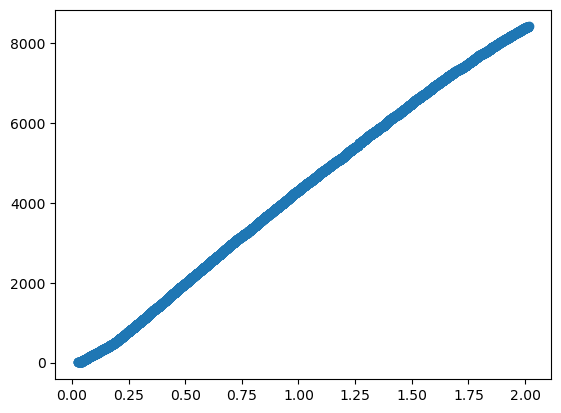

In [28]:
plt.scatter(testdf['VolumeAnalyzed'],testdf['RoiNumber'])
plt.show
    